In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.optimizers import Adam
from keras import utils
from utils import *

In [2]:
with open(os.path.dirname(os.getcwd()) + "/outputs/columns_to_remove.json", 'r') as f:
    cols_to_remove = json.load(f)
print(*cols_to_remove[:5], sep='\n')

F0semitoneFrom27.5Hz_sma3nz_amean
F0semitoneFrom27.5Hz_sma3nz_percentile80.0
F0semitoneFrom27.5Hz_sma3nz_percentile20.0
F0semitoneFrom27.5Hz_sma3nz_percentile50.0
loudness_sma3_percentile50.0


In [3]:
df_dict , max_rows, num_features = read_conv(train=True, cols_to_remove=cols_to_remove)
features, depression_labels, gender_labels = prep_conv_data(df_dict, max_rows, num_features)

Removing null values present in spk_402.csv


In [4]:
# define and train CNN Model
utils.set_random_seed(3)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (2, 2), padding = "same", use_bias = True, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
                           input_shape=(max_rows, num_features, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (2, 2),  padding = "same",use_bias = True,strides = (1,1),activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding = "same", use_bias = True,
                            kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 378, 61, 32)       160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 189, 30, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 189, 30, 64)       8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 94, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 15, 64)        16448     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 47, 7, 64)         0

In [5]:
history = model.fit(features, depression_labels, epochs=100, batch_size=16, validation_split=0.15)

Epoch 1/100
5/5 [==============================] - 1s 107ms/step - loss: 13.1927 - accuracy: 0.5068 - val_loss: 1.5243 - val_accuracy: 0.7857
Epoch 2/100
5/5 [==============================] - 0s 83ms/step - loss: 17.6413 - accuracy: 0.5753 - val_loss: 1.6617 - val_accuracy: 0.8571
Epoch 3/100
5/5 [==============================] - 0s 78ms/step - loss: 15.7907 - accuracy: 0.6164 - val_loss: 1.7035 - val_accuracy: 0.8571
Epoch 4/100
5/5 [==============================] - 0s 79ms/step - loss: 15.5713 - accuracy: 0.6027 - val_loss: 1.6371 - val_accuracy: 0.7857
Epoch 5/100
5/5 [==============================] - 0s 77ms/step - loss: 11.8824 - accuracy: 0.5890 - val_loss: 1.6675 - val_accuracy: 0.7857
Epoch 6/100
5/5 [==============================] - 0s 91ms/step - loss: 15.6417 - accuracy: 0.6027 - val_loss: 1.7055 - val_accuracy: 0.7857
Epoch 7/100
5/5 [==============================] - 0s 79ms/step - loss: 12.2061 - accuracy: 0.5479 - val_loss: 1.7453 - val_accuracy: 0.7143
Epoch 8/100


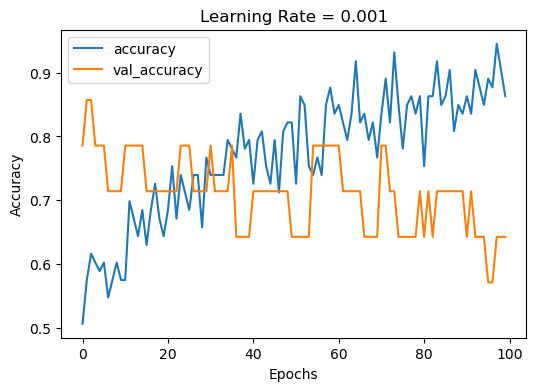

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Learning Rate = 0.001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [7]:
test_df_dict , _, _ = read_conv(train=False, cols_to_remove=cols_to_remove)
test_features, test_depression_labels, test_gender_labels = prep_conv_data(test_df_dict, max_rows, num_features)

In [8]:
test_loss, test_acc = model.evaluate(test_features,  test_depression_labels)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc)

1/1 [==============================] - 0s 39ms/step - loss: 1.4904 - accuracy: 0.7500
Test loss:  1.4904026985168457
Test accuracy:  0.75


1/1 [==============================] - 0s 77ms/step
Classification Report 
               precision    recall  f1-score   support

         0.0       0.74      1.00      0.85        14
         1.0       1.00      0.17      0.29         6

    accuracy                           0.75        20
   macro avg       0.87      0.58      0.57        20
weighted avg       0.82      0.75      0.68        20



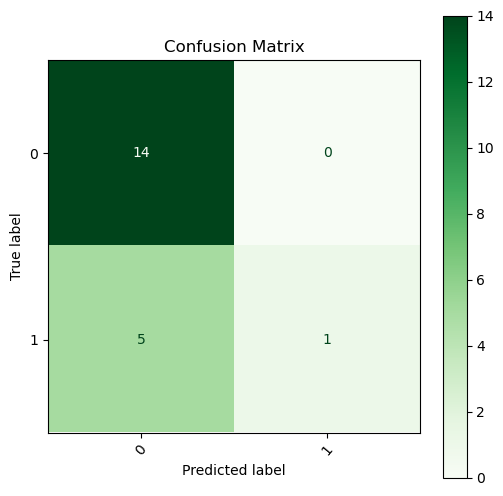

In [9]:
#Making predictions for the test set with the CNN model from b)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(test_features)
y_pred_classes = np.where(y_pred>0.5,1,0)

print("Classification Report \n", classification_report(test_depression_labels, y_pred_classes))

#Visualizing the confusion matrix
conf_matrix = confusion_matrix(test_depression_labels, y_pred_classes)
plt.rcParams['figure.figsize'] = (6, 6)
display_c_m = ConfusionMatrixDisplay(conf_matrix)
display_c_m.plot(cmap='Greens', xticks_rotation=50)
plt.title('Confusion Matrix')
plt.show()